# 7.2. 使用块的网络（VGG）

研究人员开始从单个神经元的角度思考问题，发展到整个层，现在又转向块，重复层的模式。

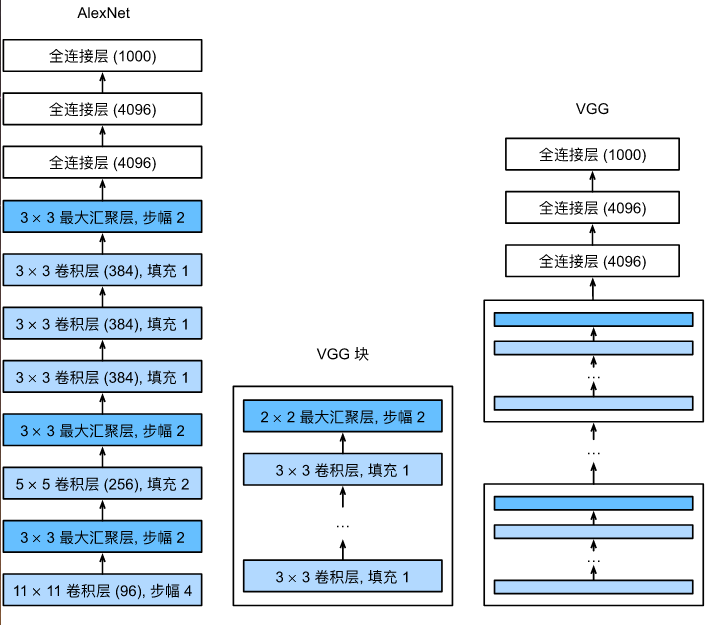

# 7.2.1. VGG块

一个VGG块由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# vgg block
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

# 7.2.2. VGG网络

In [3]:
# vgg-11
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [ ]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [4]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels=in_channels, out_channels=out_channels))
        in_channels = out_channels     # 前一个输出=后一个输入
    
    # Linear layers
    conv_blks.append(nn.Flatten())
    conv_blks.append(nn.Linear(out_channels * 7 * 7, 4096))
    conv_blks.append(nn.ReLU())
    conv_blks.append(nn.Dropout(0.5))
    conv_blks.append(nn.Linear(4096, 4096))
    conv_blks.append(nn.ReLU())
    conv_blks.append(nn.Dropout(0.5))
    conv_blks.append(nn.Linear(4096, 10))
    
    return nn.Sequential(*conv_blks)    

In [5]:
net = vgg(conv_arch)

In [6]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


# 7.2.3. 训练模型

In [7]:
# 由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络，足够用于训练Fashion-MNIST数据集
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.097, train acc 0.964, test acc 0.926
271.9 examples/sec on cuda:0


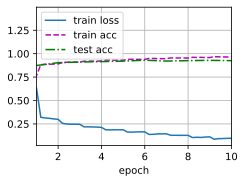

In [11]:
lr, num_epochs, batch_size = 0.05, 10, 32
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs=num_epochs, lr=lr, device=d2l.try_gpu())

# 7.2.4. 小结

VGG-11使用可复用的卷积块构造网络。不同的VGG模型可通过每个块中卷积层数量和输出通道数量的差异来定义。

块的使用导致网络定义的非常简洁。使用块可以有效地设计复杂的网络。

在VGG论文中，Simonyan和Ziserman尝试了各种架构。特别是他们发现深层且窄的卷积（即3X3）比较浅层且宽的卷积更有效。

# 7.2.5. 练习